elapsed time: 0.399673593 seconds

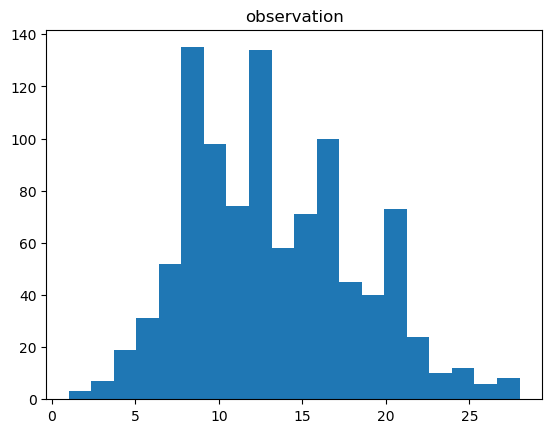

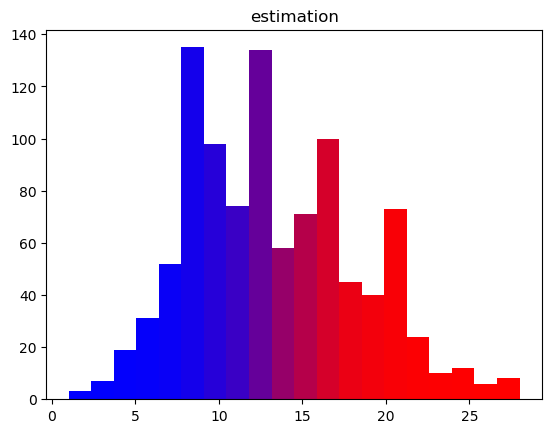

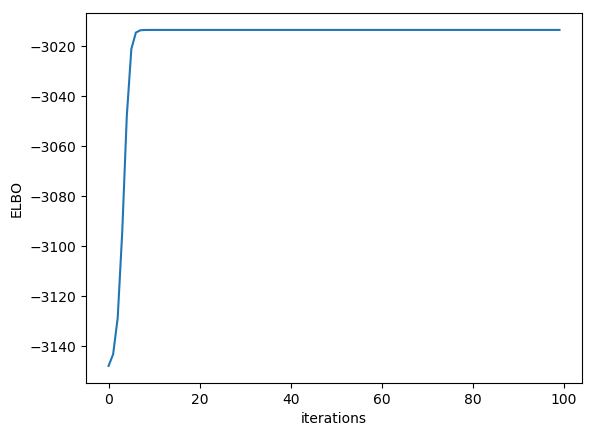

In [2]:
###################################
## Example code
## for Bayesian Poisson Mixture Model

push!(LOAD_PATH,".")
using PyPlot, PyCall
import PoissonMixtureModel

"""
Visualize data & estimation in 2D space.
"""
function visualize_2D(X::Matrix{Float64}, S::Matrix{Float64}, S_est::Matrix{Float64}, text)
    cmp = get_cmap("jet")

    K1 = size(S, 1)
    K2 = size(S_est, 1)
    col1 = [pycall(cmp.o, PyAny, Int(round(val)))[1:3] for val in linspace(0,255,K1)]    
    col2 = [pycall(cmp.o, PyAny, Int(round(val)))[1:3] for val in linspace(0,255,K2)]    

    f, (ax1, ax2) = subplots(1,2,num=text)
    f[:clf]()
    f, (ax1, ax2) = subplots(1,2,num=text)
    
    for k in 1 : K1
        ax1[:scatter](X[1, S[k,:].==1], X[2, S[k,:].==1], color=col1[k])
    end
    ax1[:set_title]("truth")
    
    for k in 1 : K2
        ax2[:scatter](X[1, S_est[k,:].==1], X[2, S_est[k,:].==1], color=col2[k])
    end

    ax2[:set_title]("estimation")
end

function draw_hist(ax, X, S, label)
    counts, bins, patches = ax[:hist](X', 20)
    for i in 1 : length(patches)
        if counts[i] > 0
            S_tmp = S[:,bins[i] .<= X[1,:] .<= bins[i+1]]
            S_sum = sum(S_tmp, 2) / sum(S_tmp)
            patches[i][:set_facecolor]((S_sum[1], 0, S_sum[2]))
        end
    end
    ax[:set_title](label)
end

"""
Visualize data & estimation using 1D histogram.
"""
function visualize_1D(X::Matrix{Float64}, S::Matrix{Float64}, S_est::Matrix{Float64})
    # separated figures
    f1, ax1 = subplots(1,1,num="observation")
    f2, ax2 = subplots(1,1,num="estimation")
    f1[:clf]()
    f2[:clf]()
    _, ax1 = subplots(1,1,num="observation")
    _, ax2 = subplots(1,1,num="estimation")
    ax1[:hist](X', 20)
    ax1[:set_title]("observation")
    draw_hist(ax2, X, S_est, "estimation")    
end

"""
Run a test script for 1D data clustering.
"""
function test_1D()
    ## set model
    D = 1 # data dimension, must be 1.
    K = 2 #  number of mixture components, must be 2.
    alpha = 100.0 * ones(K)
    cmp = [PoissonMixtureModel.Gam(1.0*ones(D), 0.01) for i in 1 : K]
    bpmm = PoissonMixtureModel.BPMM(D, K, alpha, cmp)
    
    ## generate data
    N = 1000
    pmm = PoissonMixtureModel.sample_PMM(bpmm)
    X, S = PoissonMixtureModel.sample_data(pmm, N)
    
    ## inference
    max_iter = 100
    tic()
    S_est, post_bpmm, VB = PoissonMixtureModel.learn_VI(X, bpmm, max_iter)
    #S_est, post_bpmm, VB = PoissonMixtureModel.learn_GS(X, bpmm, max_iter)
    #S_est, post_bpmm, VB = PoissonMixtureModel.learn_CGS(X, bpmm, max_iter)
    toc()

    ## plot
    visualize_1D(X, S, S_est)

    figure("ELBO")
    clf()
    plot(VB)
    ylabel("ELBO")
    xlabel("iterations")
    show()
end

"""
Run a test script for 2D data clustering.
"""
function test_2D()
    ## set model
    D = 2 # data dimension, must be 2.
    K = 8 # number of mixture components
    #K = 5

    alpha = 100.0 * ones(K)
    cmp = [PoissonMixtureModel.Gam(1.0*ones(D), 0.01) for i in 1 : K]
    bpmm = PoissonMixtureModel.BPMM(D, K, alpha, cmp)
    
    ## generate data
    N = 300
    pmm = PoissonMixtureModel.sample_PMM(bpmm)
    X, S = PoissonMixtureModel.sample_data(pmm, N)
    
    ## inference
    max_iter = 100
    tic()
    S_est, post_bpmm, VB = PoissonMixtureModel.learn_VI(X, bpmm, max_iter)
    #S_est, post_bpmm, VB = PoissonMixtureModel.learn_GS(X, bpmm, max_iter)
    #S_est, post_bpmm, VB = PoissonMixtureModel.learn_CGS(X, bpmm, max_iter)
    toc()

    ## plot
    visualize_2D(X, S, PoissonMixtureModel.winner_takes_all(S_est), "2D plot")

    # VB check
    figure("ELBO")
    clf()
    plot(VB)
    ylabel("ELBO")
    xlabel("iterations")
    show()
end

test_1D()
#test_2D()